# Georgia
We will be analyzing the congressional district maps in Georgia followwing the 2020 census. Currently Georgia's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election. We will be looking at their 2021 plan which was used for the 2022 election and then a new 2023 plan which was used in the 2024 election. The 2023 plan was a placeholder to fix some of the issues with the 2021 so the 2024 election would have a less problematic map.

## Import Required Packages

In [36]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup

## Import Plans

In [37]:
ga_2023_gdf = gpd.read_file("congress-2023-shape/Congress-2023-shape.shp")
ga_2021_gdf = gpd.read_file("congress-prop1-2021-shape/CONGRESS-PROP1-2021-shape.shp")

<Axes: >

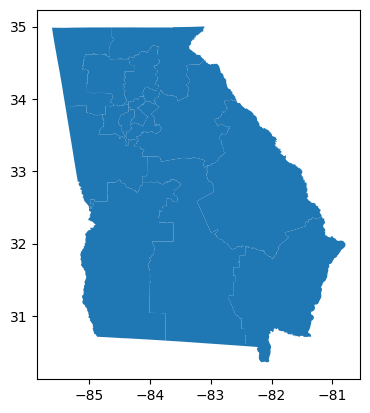

In [38]:
ga_2023_gdf.plot()

<Axes: >

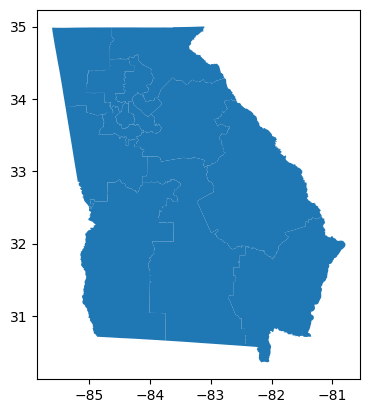

In [39]:
ga_2021_gdf.plot()

We need to confirm that there aren't any issues in the Districts, so we can use the "maup" package.

In [40]:
# Check geodataframe using maup's doctor function
maup.doctor(ga_2023_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

In [41]:
maup.doctor(ga_2021_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

We are good to use these shapefiles.

## Import Election Data

In [42]:
# Import 2022 General Election voting data
ga_data_gdf = gpd.read_file('ga_2022_gen_prec/ga_2022_gen_st_prec/ga_2022_gen_st_prec.shp')
ga_data_gdf.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct', 'G22A01NO', 'G22A01YES',
       'G22A02NO', 'G22A02YES', 'G22AGRDHEM', 'G22AGRLRAU', 'G22AGRRHAR',
       'G22ATGDJOR', 'G22ATGLCOW', 'G22ATGRCAR', 'G22GOVDABR', 'G22GOVLHAZ',
       'G22GOVRKEM', 'G22INSDROB', 'G22INSRKIN', 'G22LABDBOD', 'G22LABLAND',
       'G22LABRTHO', 'G22LTGDBAI', 'G22LTGLGRA', 'G22LTGRJON', 'G22RFANO',
       'G22RFAYES', 'G22RFBNO', 'G22RFBYES', 'G22SOSDNGU', 'G22SOSLMET',
       'G22SOSRRAF', 'G22SUPDSEA', 'G22SUPRWOO', 'G22USSDWAR', 'G22USSLOLI',
       'G22USSRWAL', 'geometry'],
      dtype='object')

In [43]:
# List of specific columns to keep
columns_to_keep = ['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct']

# Add columns starting with 'G22USS'
filtered_columns = columns_to_keep + [col for col in ga_data_gdf.columns if col.startswith('G22USS')]

# Filter the GeoDataFrame
ga_data_gdf = ga_data_gdf[filtered_columns]

In [44]:
ga_data_gdf.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct', 'G22USSDWAR',
       'G22USSLOLI', 'G22USSRWAL'],
      dtype='object')

In [45]:
ga_data_gdf.head()

,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL
0,001-1B,1,Appling,1B,86,15,721
1,001-1C,1,Appling,1C,51,6,571
2,001-2,1,Appling,2,641,11,393
3,001-3A1,1,Appling,3A1,23,8,493
4,001-3C,1,Appling,3C,213,5,726


Need to add district to this so we are going to left join with data from general election congressional precinct data but only add the district column.

In [46]:
# Import 2022 General Election data but it has what congressional district each precinct is in
ga_data_cong_gdf = gpd.read_file('ga_2022_gen_prec/ga_2022_gen_cong_prec/ga_2022_gen_cong_prec.shp')
ga_data_cong_gdf.head()

,UNIQUE_ID,COUNTYFP,county,precinct,CONG_DIST,GCON01DHER,GCON01RCAR,GCON02DBIS,GCON02RWES,GCON03DALM,...,GCON10RCOL,GCON11DDAZ,GCON11RLOU,GCON12DJOH,GCON12RALL,GCON13DSCO,GCON13RGON,GCON14DFLO,GCON14RGRE,geometry
0,021-VINEVILLE 6-(CONG-02),21,Bibb,Vineville 6,02,0,0,433,305,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-83.66243 32.85187, -83.66242 32.851..."
1,215-CHATTAHOOCHEE-(CONG-02),215,Muscogee,Chattahoochee,02,0,0,1409,1976,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.96698 32.54237, -84.96701 32.542..."
2,215-COLUMBUS TECH-(CONG-02),215,Muscogee,Columbus Tech,02,0,0,607,500,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.97207 32.50868, -84.97223 32.508..."
3,215-ST PAUL-(CONG-02),215,Muscogee,St Paul,02,0,0,1186,1553,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.94815 32.47774, -84.94831 32.477..."
4,021-VINEVILLE 6-(CONG-08),21,Bibb,Vineville 6,08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-83.68905 32.86310, -83.68918 32.863..."


In [47]:
# Merge election dataset with the dataset designating congressional district to precincts
ga_data_gdf = ga_data_gdf.merge(ga_data_cong_gdf[["county", "precinct", "CONG_DIST"]], on=['county', 'precinct'], how='left')
ga_data_gdf['CONG_DIST'] = ga_data_gdf['CONG_DIST'].astype(str).str.lstrip('0')

In [48]:
ga_data_gdf.head()

,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST
0,001-1B,1,Appling,1B,86,15,721,1
1,001-1C,1,Appling,1C,51,6,571,1
2,001-2,1,Appling,2,641,11,393,1
3,001-3A1,1,Appling,3A1,23,8,493,1
4,001-3C,1,Appling,3C,213,5,726,1


In [49]:
# Check it merged correctly
ga_data_gdf[pd.isna(ga_data_gdf['CONG_DIST'])]

,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST


## Join Voting Data to Shapefiles

Now we will add the election data to the congressional map shapefiles

In [50]:
# Remove leading zeros so the district data is in the same format as the election data
ga_2023_gdf['DISTRICT'] = ga_2023_gdf['DISTRICT'].astype(str).str.lstrip('0')
ga_2021_gdf['DISTRICT'] = ga_2021_gdf['DISTRICT'].astype(str).str.lstrip('0')

In [51]:
# Join the election data to the 2023 congressional map
ga_2023_gdf = ga_2023_gdf.merge(ga_data_gdf, left_on='DISTRICT', right_on='CONG_DIST', how='inner')

In [52]:
# Check the merge worked
ga_2023_gdf[pd.isna(ga_2023_gdf['CONG_DIST'])]

,ID,AREA,DATA,DISTRICT,POPULATION,F18_POP,NH_WHT,NH_BLK,HISPANIC_O,NH_ASN,...,DISTRICT_L,geometry,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST


In [53]:
ga_2023_gdf.head()

,ID,AREA,DATA,DISTRICT,POPULATION,F18_POP,NH_WHT,NH_BLK,HISPANIC_O,NH_ASN,...,DISTRICT_L,geometry,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST
0,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-ANNA,7,Baker,Anna,141,2,140,2
1,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-ELMODEL,7,Baker,Elmodel,56,0,137,2
2,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-HOGGARDS MILL,7,Baker,Hoggards Mill,151,6,104,2
3,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-MILFORD,7,Baker,Milford,76,3,198,2
4,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-NEWTON,7,Baker,Newton,102,1,132,2


In [54]:
# Join the election data to the 2021 congressional map
ga_2021_gdf = ga_2021_gdf.merge(ga_data_gdf, left_on='DISTRICT', right_on='CONG_DIST', how='inner')

In [55]:
# Check the merge worked
ga_2021_gdf[pd.isna(ga_2021_gdf['CONG_DIST'])]

,ID,AREA,DATA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,NH_WHT,...,IDEAL_VALU,geometry,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST


In [56]:
ga_2021_gdf.head()

,ID,AREA,DATA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,NH_WHT,...,IDEAL_VALU,geometry,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST
0,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-ELLENWOOD 1,63,Clayton,Ellenwood 1,1599,12,84,13
1,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-ELLENWOOD 2,63,Clayton,Ellenwood 2,1825,11,110,13
2,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-FOREST PARK 4,63,Clayton,Forest Park 4,476,12,209,13
3,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-FOREST PARK 5,63,Clayton,Forest Park 5,1004,20,197,13
4,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-FOREST PARK 6,63,Clayton,Forest Park 6,434,9,169,13


## Analysis of maps by senate voting
We want to determine what party would have won the election for the U.S. House of Representative in each district for each of the two maps we have for Georgia. However, instead of using House candidates, we will be using U.S. Senate candidates because those were elected across the whole state. Thus, we will be using the Senate election as a placeholder for the House election because in the next party, once we move the congressional district boundary using a random walk, the candidates for the House would change. We are assuming voters would vote by party so we will use a statewide election where there were two candidates, one from each party, to determine how each voters would vote in a new House election.

### 2021 Congressional Map

We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2021 congressional districting map. In 2022, there were three candidates that ran for the U.S. Senate: Democrat Raphael Warnock (G22USSDWAR), Libertarian Chase Oliver (G22USSLOLI), and Republican Herschel Junior Walker (G22USSRWAL).

In [57]:
# Group by congressional district and calculate total votes for each candidate
district_totals = ga_2021_gdf.groupby('DISTRICT')[['G22USSDWAR', 'G22USSRWAL', 'G22USSLOLI']].sum()

# Determine the winning party in each district
district_totals['Winner'] = np.where(
    (district_totals['G22USSDWAR'] > district_totals['G22USSRWAL']) & (district_totals['G22USSDWAR'] > district_totals['G22USSLOLI']),
    "Democrat",
    np.where(
        (district_totals['G22USSRWAL'] > district_totals['G22USSDWAR']) & (district_totals['G22USSRWAL'] > district_totals['G22USSLOLI']),
        "Republican",
        "Libertarian"
    )
)

# Reset index to turn District back into a column (optional)
district_totals_2021 = district_totals.reset_index()

print(district_totals_2021)

   DISTRICT  G22USSDWAR  G22USSRWAL  G22USSLOLI      Winner
0         1      112701      147908        4742  Republican
1        10      120483      187712        6843  Republican
2        11      134994      176447        9222  Republican
3        12      114413      150521        3944  Republican
4        13      228139       47810        4095    Democrat
5        14       85675      176092        6301  Republican
6         2      131503      109100        3112    Democrat
7         3      114843      202738        7593  Republican
8         4      228125       54603        4995    Democrat
9         5      254275       43060        4695    Democrat
10        6      144653      191204       10128  Republican
11        7      148556       83108        5637    Democrat
12        8       90283      168933        4098  Republican
13        9       86853      200997        7901  Republican


In [58]:
# Count the number of districts won by each party
winner_summary_2021 = district_totals_2021['Winner'].value_counts()

print(winner_summary_2021)

Winner
Republican    9
Democrat      5
Name: count, dtype: int64


<Axes: >

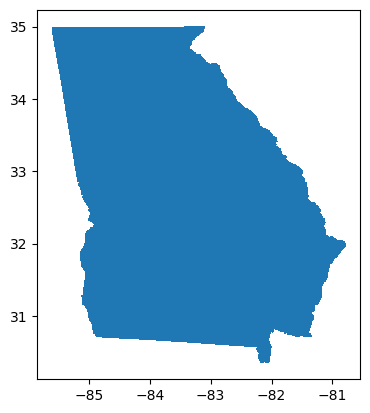

In [59]:
ga_2021_gdf.plot() # Plot by district, R and D

## 2023 Congressional Map
We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2023 congressional districting map. Since we are using the same senate election as above, the candidates in 2022 were the same: Democrat Raphael Warnock (G22USSDWAR), Libertarian Chase Oliver (G22USSLOLI), and Republican Herschel Junior Walker (G22USSRWAL).

In [60]:
# Group by congressional district and calculate total votes for each candidate
district_totals = ga_2021_gdf.groupby('DISTRICT')[['G22USSDWAR', 'G22USSRWAL', 'G22USSLOLI']].sum()

# Determine the winning party in each district
district_totals['Winner'] = np.where(
    (district_totals['G22USSDWAR'] > district_totals['G22USSRWAL']) & (district_totals['G22USSDWAR'] > district_totals['G22USSLOLI']),
    "Democrat",
    np.where(
        (district_totals['G22USSRWAL'] > district_totals['G22USSDWAR']) & (district_totals['G22USSRWAL'] > district_totals['G22USSLOLI']),
        "Republican",
        "Libertarian"
    )
)

# Reset index to turn District back into a column (optional)
district_totals_2023 = district_totals.reset_index()

print(district_totals_2023)

   DISTRICT  G22USSDWAR  G22USSRWAL  G22USSLOLI      Winner
0         1      112701      147908        4742  Republican
1        10      120483      187712        6843  Republican
2        11      134994      176447        9222  Republican
3        12      114413      150521        3944  Republican
4        13      228139       47810        4095    Democrat
5        14       85675      176092        6301  Republican
6         2      131503      109100        3112    Democrat
7         3      114843      202738        7593  Republican
8         4      228125       54603        4995    Democrat
9         5      254275       43060        4695    Democrat
10        6      144653      191204       10128  Republican
11        7      148556       83108        5637    Democrat
12        8       90283      168933        4098  Republican
13        9       86853      200997        7901  Republican


In [61]:
# Count the number of districts won by each party
winner_summary_2023 = district_totals_2023['Winner'].value_counts()

print(winner_summary_2023)

Winner
Republican    9
Democrat      5
Name: count, dtype: int64


In [62]:
to_plot = ga_2023_gdf.merge(district_totals_2023[["DISTRICT", "Winner"]], on='DISTRICT', how='left')

<Axes: >

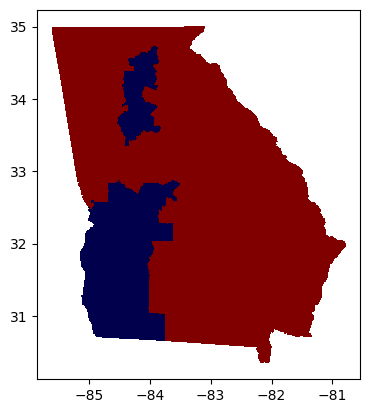

In [63]:
to_plot.plot(column = "Winner", cmap = "seismic") # but i want to see the districts

<Axes: >

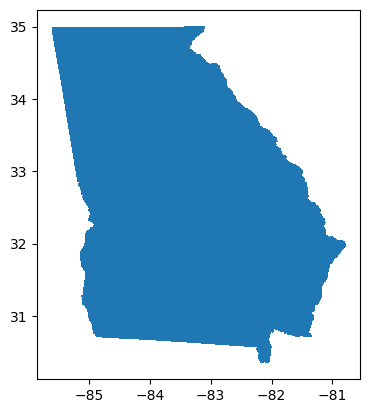

In [64]:
ga_2023_gdf.plot()